In [1]:
import pandas as pd
import numpy as np
import io
import requests
from sklearn.impute import SimpleImputer


# mushrooms dataset
url = "https://www.wolframcloud.com/obj/d0c0084e-0b60-46db-a4d9-beb33412905e"
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,StalkRoot,StalkSurfaceAboveRing,StalkSurfaceBelowRing,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat,Class
0,convex,smooth,brown,True,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban,poisonous
1,convex,smooth,yellow,True,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses,edible
2,bell,smooth,white,True,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows,edible
3,convex,scaly,white,True,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban,poisonous
4,convex,smooth,gray,False,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses,edible


**Подготовка набора данных**

**Dataset preparation**

In [2]:
rows, columns = data.shape
print('rows = {}; columns = {}'.format(rows, columns), '\n\n')

# go through each dataset column and check unique values to find empty one (like NaN or Missing[])
for col in data.columns:
  print('{}: {}'.format(col, data[col].unique()))

rows = 8124; columns = 23 


CapShape: ['convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical']
CapSurface: ['smooth' 'scaly' 'fibrous' 'grooves']
CapColor: ['brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'purple' 'cinnamon'
 'green']
Bruises: [ True False]
Odor: ['pungent' 'almond' 'anise' 'none' 'foul' 'creosote' 'fishy' 'spicy'
 'musty']
GillAttachment: ['free' 'attached']
GillSpacing: ['close' 'crowded']
GillSize: ['narrow' 'broad']
GillColor: ['black' 'brown' 'gray' 'pink' 'white' 'chocolate' 'purple' 'red' 'buff'
 'green' 'yellow' 'orange']
StalkShape: ['enlarging' 'tapering']
StalkRoot: ['equal' 'club' 'bulbous' 'rooted' 'Missing[]']
StalkSurfaceAboveRing: ['smooth' 'fibrous' 'silky' 'scaly']
StalkSurfaceBelowRing: ['smooth' 'fibrous' 'scaly' 'silky']
StalkColorAboveRing: ['white' 'gray' 'pink' 'brown' 'buff' 'red' 'orange' 'cinnamon' 'yellow']
StalkColorBelowRing: ['white' 'pink' 'gray' 'buff' 'brown' 'red' 'yellow' 'orange' 'cinnamon']
VeilType: ['partial']
VeilColor: ['whit

In [3]:
"""
on initial viewing it seems that we have single column
with absence of values in rows: this column is StalkRoot and
absence of values is indicated like Missing[]
"""

# Take a look at columns more precisely to ensure that this column is single with absence of values
for col in data.columns:
    # Missing[] amount 
    temp_null_count = data[data[col] == 'Missing[]'].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        temp_perc = round((temp_null_count / rows) * 100.0, 2)
        print('Column {}. Data type {}. amount of Missing[] values {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Column StalkRoot. Data type object. amount of Missing[] values 2480, 30.53%.


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
data['StalkRoot'].unique()

array(['equal', 'club', 'bulbous', 'rooted', 'Missing[]'], dtype=object)

In [5]:
# impute data with most frequent values
imputation = SimpleImputer(missing_values='Missing[]', strategy='most_frequent')
data_imputed = imputation.fit_transform(data[['StalkRoot']])
np.unique(data_imputed)

array(['bulbous', 'club', 'equal', 'rooted'], dtype=object)

In [6]:
# put imputed data in our dataset
for i in range(rows):
  data['StalkRoot'][i] = data_imputed[i][0]
data['StalkRoot'].unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['equal', 'club', 'bulbous', 'rooted'], dtype=object)

In [7]:
# now we`ll transform categorical columns to columns with values in [0, 1]
object_columns = []

# initially, find amount of unique values for each column
# and add categorical columns to object_columns
for column in data.columns:
    dt = str(data[column].dtype)
    amount_unique = len(pd.unique(data[column]))
    print('{}: {}, {}'.format(column, amount_unique, dt))
    if dt == 'object':
        object_columns.append({'column': column, 'amount': amount_unique})

CapShape: 6, object
CapSurface: 4, object
CapColor: 10, object
Bruises: 2, bool
Odor: 9, object
GillAttachment: 2, object
GillSpacing: 2, object
GillSize: 2, object
GillColor: 12, object
StalkShape: 2, object
StalkRoot: 4, object
StalkSurfaceAboveRing: 4, object
StalkSurfaceBelowRing: 4, object
StalkColorAboveRing: 9, object
StalkColorBelowRing: 9, object
VeilType: 1, object
VeilColor: 4, object
RingNumber: 3, int64
RingType: 5, object
SporePrintColor: 9, object
Population: 6, object
Habitat: 7, object
Class: 2, object


In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [0]:
"""
after oneHot encoding for single value we`ll have something like this [0.0, 1.0, 0.0, 0.0, ...]
but we need to have just a number - so this function will normalize it with next formula:
norm_val = (N - i) / N, where
N - amount of unique values for our column
i - index of 1.0 in values [0.0, 1.0, 0.0, 0.0, ...] before normalizing
so for example if we`ll have 10 different values - then in normalized view it will variating
from 0.1 (if index = 9) to 1.0 (if index = 0)
"""
def from_bytes_to_num(col_in_arr, uniquie_amount):
    normalized_col = []
    for value in col_in_arr:
        normalized_value = (uniquie_amount - np.where(value == 1.0)[0][0]) / uniquie_amount
        normalized_col.append(float("{0:.4f}".format(normalized_value))) # digits after float point
    return normalized_col


normalized_data = []
for col in object_columns:
    uniquie_amount = col['amount']
    col_name = col['column']

    #encode with oneHot
    column_after_encoding = ohe.fit_transform(data[[col_name]])

    #fetch it to array
    col_in_arr = column_after_encoding.toarray()

    #normilizing column values
    normalized_col = from_bytes_to_num(col_in_arr, uniquie_amount)

    normalized_data.append({'column': col_name, 'data': normalized_col})

In [10]:
#set normalized values for general dataset
for col in normalized_data:
    col_in_dataFrame = pd.DataFrame(data={col['column']: col['data']})
    data[col['column']] = col_in_dataFrame

data

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,StalkRoot,StalkSurfaceAboveRing,StalkSurfaceBelowRing,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat,Class
0,0.6667,0.25,1.0,True,0.2222,0.5,1.0,0.5,1.0000,1.0,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,1.0000,0.5000,0.4286,0.5
1,0.6667,0.25,0.1,True,1.0000,0.5,1.0,1.0,1.0000,1.0,0.75,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,0.8889,0.6667,1.0000,1.0
2,1.0000,0.25,0.2,True,0.8889,0.5,1.0,1.0,0.9167,1.0,0.75,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,0.8889,0.6667,0.7143,1.0
3,0.6667,0.50,0.2,True,0.2222,0.5,1.0,0.5,0.9167,1.0,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,1.0000,0.5000,0.4286,0.5
4,0.6667,0.25,0.7,False,0.3333,0.5,0.5,1.0,1.0000,0.5,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,1.0,0.8889,1.0000,1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.3333,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.0833,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,0.75,1,0.2,0.7778,0.8333,0.8571,1.0
8120,0.6667,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.0833,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,1.00,1,0.2,0.7778,0.3333,0.8571,1.0
8121,0.5000,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.9167,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,0.75,1,0.2,0.7778,0.8333,0.8571,1.0
8122,0.3333,0.50,1.0,False,0.6667,0.5,1.0,0.5,0.8333,0.5,1.00,0.25,0.50,0.2222,0.2222,1.0,0.50,1,1.0,0.2222,0.3333,0.8571,0.5


**Разделение данных**

**Data splitting**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

dcopy = data.copy()

X = dcopy.drop("Class", axis=1)
y = dcopy["Class"]
print(X.head(), "\n")
print(y.head())

   CapShape  CapSurface  CapColor  ...  SporePrintColor  Population  Habitat
0    0.6667        0.25       1.0  ...           1.0000      0.5000   0.4286
1    0.6667        0.25       0.1  ...           0.8889      0.6667   1.0000
2    1.0000        0.25       0.2  ...           0.8889      0.6667   0.7143
3    0.6667        0.50       0.2  ...           1.0000      0.5000   0.4286
4    0.6667        0.25       0.7  ...           0.8889      1.0000   1.0000

[5 rows x 22 columns] 

0    0.5
1    1.0
2    1.0
3    0.5
4    1.0
Name: Class, dtype: float64


In [12]:
# divide train and test selections
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6093, 22)
(2031, 22)
(6093,)
(2031,)


**Обучение моделей**

**Model training**

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

**Случайный лес**

**Random forest**

In [29]:
from sklearn.ensemble import RandomForestRegressor

ran_80 = RandomForestRegressor(n_estimators=80)
ran_80.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
test_model(ran_80)

mean_absolute_error: 0.0
median_absolute_error: 0.0
r2_score: 1.0


**Градиентный бустинг**

**Gradient Boost**

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gr_80 = GradientBoostingRegressor(n_estimators=80)
gr_80.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
test_model(gr_80)

mean_absolute_error: 0.006802494393104271
median_absolute_error: 0.0010510475336632519
r2_score: 0.9900409523010036


**Подбор гиперпараметра n**

**Hyperparameter n selection**

**Случайный лес**

**Random forest**

In [46]:
param_range = np.arange(50, 170, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160])}]

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

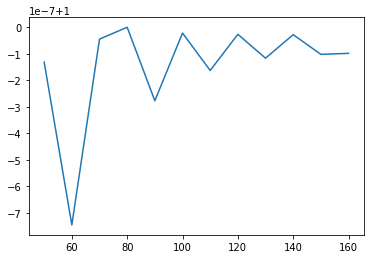

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(param_range, gs.cv_results_["mean_train_score"]);

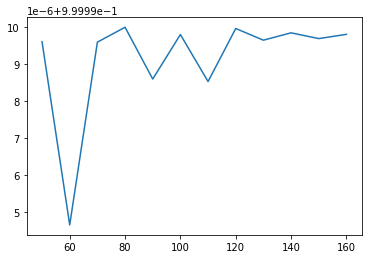

In [49]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [50]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 6.154603643525363e-05
median_absolute_error: 0.0
r2_score: 0.9999753811019957


**Градиентный бустинг**

**Gradient Boost**

In [28]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

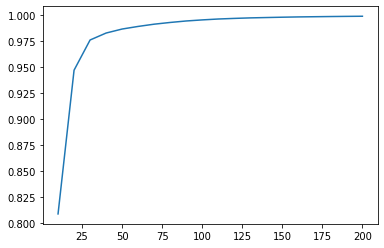

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

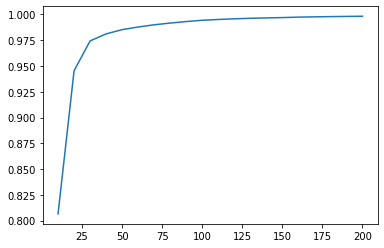

In [34]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [35]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.0028189626630988947
median_absolute_error: 0.0005545827653701263
r2_score: 0.9980449702667502
